In [23]:
## All pooled survey data

In [2]:
# all imported libraries    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
# linear regression & scaler & train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Importing the Data

In [3]:
# Load the data from all 3 survey csvs
# add data from multiple csvs to 1 dataframe
survey1 = pd.read_csv('data/umfrage-nachhaltige-mobilitaet_FHDW.csv')
survey2 = pd.read_csv('data/umfrage-nachhaltige-mobilitaet_bekannte.csv')
survey3 = pd.read_csv('data/umfrage-nachhaltige-mobilitaet_offen.csv')
# add a column to each survey to indicate the survey number
survey1['survey'] = 1
survey2['survey'] = 2
survey3['survey'] = 3
# concatenate the 3 surveys
survey_data = pd.concat([survey1, survey2, survey3])
survey_data

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?,survey
0,2024/04/22 1:28:30 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,6.0,80%,20%,bessere Sauberkeit;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;mehr R...,1
1,2024/04/22 1:29:15 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,1.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,Wenn ich am Arsch der Welt wohnen würde,1
2,2024/04/22 1:29:21 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,10%,90%,bessere Sauberkeit;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...,1
3,2024/04/22 1:29:33 PM OEZ,20-25,Wohneigentum,Haus,Stadt,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
4,2024/04/22 1:31:53 PM OEZ,20-25,gemietet,Wohnung,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2024/04/24 11:55:29 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,3400,kein Auto,9.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...,3
8,2024/04/24 1:09:55 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1900,kein Auto,NaN,0%,90%,günstigere Preise;kürzere Wartezeit zwischen z...,Ich will kein Auto,3
9,2024/04/24 1:50:28 PM OEZ,16-19,Wohneigentum,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,NaN,kein Auto,3.0,30%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...,3
10,2024/04/25 2:45:38 AM OEZ,26-35,gemietet,Wohnung,Land,Angestellter,40.000,kein Auto,NaN,0%,40%,günstigere Preise;bessere Zuverlässigkeit;Höhe...,"Die Frage ist verpflichtend, also antworte ich...",3


# Methods for Data Preprocessing

In [4]:
#Constants for column names
COLUMN_NAMES = {
    'age': 'Wie alt sind Sie? ',
    'employment': 'Wie ist Ihre Beschäftigung? ',
    'monthly_income': 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)',
    'car_ownership': 'Besitzen Sie ein Auto? (auch Leasing) ',
    'interest_e_car': 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) ',
    'living_situation': 'Wie ist Ihre Wohnsituation? (Wohneigentum?) ',
    'living_situation_house_apartment': 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) ',
    'living_situation_city': 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) ',
    'mobility_car': 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) ',
    'mobility_public_transport': 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? ',
    'mobility_public_transport_attraction': 'Was würde den ÖPNV für Sie attraktiver machen? ',
    'mobility_e_car_attraction': 'Was würde E-Autos für Sie attraktiver machen? '
}
age = 'Wie alt sind Sie? '
employment = 'Wie ist Ihre Beschäftigung? '
monthly_income = 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)'
car_ownership = 'Besitzen Sie ein Auto? (auch Leasing) '
interest_e_car = 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) '
living_situation = 'Wie ist Ihre Wohnsituation? (Wohneigentum?) '
living_situation_house_apartment = 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) '
living_situation_city = 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) '
mobility_car = 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) '
mobility_public_transport = 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? '
mobility_public_transport_attraction = 'Was würde den ÖPNV für Sie attraktiver machen? '
mobility_e_car_attraction = 'Was würde E-Autos für Sie attraktiver machen? '

In [5]:
def explore_data(input_data):
    #Display a summary of the data
    # args: data: pandas dataframe
    # Summarize the data
    print(input_data.info())
    # Display the first 5 rows of the data
    print(input_data.head())
    
def drop_data(input_data):
    # Drop non-uniques and missing values
    # args: data: pandas dataframe
    # Drop duplicates
    duplicate_free_data = input_data.drop_duplicates()
    #data.drop_duplicates(inplace=True)
    # Drop missing values
    na_free_data = duplicate_free_data.dropna(inplace=True)
    # Replace missing values with the mean
    #data.fillna(data.mean(), inplace=True)
    return na_free_data

def fill_data(input_data):
    # Fill missing values with the mean
    # args: data: pandas dataframe
    #data.fillna(data.mean(), inplace=True)
    input_data.ffill().bfill()
    return input_data

# normalise age ranges to class representation
def normalise_age(input_data):
    # normalise age ranges to class representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[age] = input_data[age].replace(['0-15', '16-19', '20-25', '26-35', '36-45', '46-55', '56-65', '65+'], [7.5, 17.5, 22.5, 30.5, 40.5, 50.5, 60.5, 65])
    return input_data

# percent to numerical representation
def normalise_percent(input_data):
    # normalise percent to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    percentage_mapping = {
        '0%': 0,
        '10%': 10,
        '20%': 20,
        '30%': 30,
        '40%': 40,
        '50%': 50,
        '60%': 60,
        '70%': 70,
        '80%': 80,
        '90%': 90,
        '100%': 100
    }
    input_data[mobility_car] = input_data[mobility_car].replace(percentage_mapping)
    input_data[mobility_public_transport] = input_data[mobility_public_transport].replace(percentage_mapping)
    return input_data

def fill_missing_values(input_data, columns):
    # fill missing values with the mean
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    imputed_data = input_data.copy()
    imputer = KNNImputer(n_neighbors=3)
    
    # Ensure columns are reshaped correctly
    reshaped_column = input_data[columns]
    imputed_column = pd.DataFrame(imputer.fit_transform(reshaped_column), columns=columns)
    imputed_data[columns] = imputed_column
    
    return imputed_data
    

# remove euro sign from monthly income
def normalise_monthly_income(input_data):
    # remove euro sign from monthly income
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[monthly_income] = input_data[monthly_income].replace('€', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' euro', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' Netto', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace('netto: ', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(',', '.', regex=True)
    # convert to float for this input data
    input_data[monthly_income] = input_data[monthly_income].replace('Einkommen als SHK 300. Eltern 600', '900', regex=True)
    # fill missing values with the median
    input_data[monthly_income] = input_data[monthly_income].fillna(input_data[monthly_income].median())
    input_data[monthly_income] = input_data[monthly_income].astype(float)
    return input_data

def normalise_employment(input_data):
    # normalise employment to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    employment_mapping = {
        'Student': 1,
        'Angestellter': 2,
        'Selbstständiger': 3,
        'Arbeitslos': 4,
        'Rentner': 5,
        'Schüler': 6,
        'Azubi': 7,
        'dualer Student (impliziert Anstellung bei einem Partner Unternehmen)': 8,
        'Beamter': 9,
        'Student;Angestellter': 10,
    }
    input_data[employment] = input_data[employment].replace(employment_mapping)
    return input_data

def normalise_living_situation(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Wohneigentum': 1,
        'gemietet': 2,
    }
    input_data[living_situation] = input_data[living_situation].replace(living_mapping)
    return input_data

def normalise_living_situation_house_apartment(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Haus': 1,
        'Wohnung': 2,
        'Reihenhaus': 3,
        'Doppelhaushälfte': 4,
    }
    input_data[living_situation_house_apartment] = input_data[living_situation_house_apartment].replace(living_mapping)
    return input_data

def normalise_living_situation_city(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Großstadt (min. 100.000 Einwohner)': 1,
        'Stadt': 2,
        'Land': 3
    }
    input_data[living_situation_city] = input_data[living_situation_city].replace(living_mapping)
    return input_data

# normalise car ownership to numerical representation
def normalise_car_ownership(input_data):
    # normalise car ownership to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[car_ownership] = input_data[car_ownership].replace(['Auto', 'kein Auto', 'E-Auto'], [1, 0, 2])
    return input_data

def split_data(input_data):
    # split data for use case
    # args: data: pandas dataframe
    # Split the data into features and target
    # helper method to split the data in different use cases, not used in this notebook
    data_na_removed = input_data.dropna()
    selected_columns_finance = [age, employment, monthly_income, car_ownership, interest_e_car]
    selected_columns_mobility = [age, car_ownership, interest_e_car, mobility_car, mobility_public_transport, mobility_public_transport_attraction, mobility_e_car_attraction]
    selected_columns_living = [living_situation, living_situation_house_apartment, living_situation_city, interest_e_car] 
    selected_columns_age_employment = [age, employment, interest_e_car] 
    data_financial = input_data[selected_columns_finance]
    data_mobility = input_data[selected_columns_mobility]
    data_living = input_data[selected_columns_living]
    data_age = input_data[selected_columns_age_employment]
    return input_data, data_na_removed, data_financial, data_mobility, data_living, data_age

def prepare_data(input_data, feature_columns, target):
    # Prepare the data for analysis
    # args: data: pandas dataframe
    # args: feature_column: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: tuple: X_train, X_test, y_train, y_test
    X_var = input_data[feature_columns]
    Y_var = input_data[target]
    # Split the data into training and testing data
    X_trains, X_tests, y_train, y_test = train_test_split(X_var, Y_var, test_size=0.2, random_state=42)
    return X_trains, X_tests, y_train, y_test

def scale_data(X_train_data, X_test_data):
    # Scale the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    #return: X_train_scaled, X_test_scaled
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_data)
    X_test_scaled = scaler.transform(X_test_data)
    return X_train_scaled, X_test_scaled

def train_model(X_train_data, y_train_data):
    # Train the model
    # args: X_train: pandas dataframe
    # args: y_train: pandas dataframe
    #return: model
    model = LinearRegression()
    model.fit(X_train_data, y_train_data)
    return model

def evaluate_model(model, X_test_data, y_test_data):
    # Evaluate the model
    # args: model: model
    # args: X_test: pandas dataframe
    # args: y_test: pandas dataframe
    #return: mse
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(y_test_data, y_pred)
    return mse

def analyze_data(X_train_data, X_test_data, Y_train_data, Y_test_data):
    # Analyze the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    # args: Y_train: pandas dataframe
    # args: Y_test: pandas dataframe
    #return: mse
    # X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    # model = train_model(X_train_scaled, Y_train)
    # mse = evaluate_model(model, X_test_scaled, Y_test)
    # return mse
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(Y_test_data, y_pred)
    print('Mean Squared Error:', mse)
    return mse

def visualize_data(input_data):
    # args: data: pandas dataframe
    #return: None
    # visualize the regression line
    sns.lmplot(x=age, y=interest_e_car, data=input_data)
    plt.show()
    
def visualize_correlation(input_data):
    # args: data: pandas dataframe
    # args: feature_columns: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: None
    # drop the 'Zeitstempel' column
    input_data_copy = input_data.copy()
    input_data_copy = input_data_copy.drop('Zeitstempel', axis=1)
    input_data_copy = input_data_copy.drop(mobility_public_transport_attraction, axis=1)
    input_data_copy = input_data_copy.drop(mobility_e_car_attraction, axis=1)
    correlation_matrix = input_data_copy.corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

def process_data(input_data, X_train_data, X_test_data, Y_train_data, Y_test_data, feature_columns, target):
    # Process the data
    # args: data: pandas dataframe
    #return: None
    explore_data(input_data)
    drop_data(input_data)
    fill_data(input_data)
    split_data(input_data)
    prepare_data(input_data, feature_columns, target)
    visualize_data(input_data)
    visualize_correlation(input_data, feature_columns, target)
    analyze_data(X_train_data, X_test_data, Y_train_data, Y_test_data)
    return None

In [28]:
# method for linear regression analysis using scikit-learn
def linear_regression_analysis(input_data, feature_column, target): 
    # Split the data
    sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_column]).reshape(-1, 1)
    y = np.array(input_data[target]).reshape(-1, 1)
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
    # label the plot
    plt.xlabel(feature_column)
    plt.ylabel(target)
 
    plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

In [6]:
# method for linear regression analysis using scikit-learn for multiple features
def linear_regression_analysis_multiple_features(input_data, feature_columns, target):
    # Split the data
    #sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    #plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_columns])
    y = np.array(input_data[target])
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
    # adjust the plot to show multiple features or a combination of features
    #plt.plot(x_test, y_pred, color ='k')
 
    #plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

# Data Exploration

In [30]:
# Displaying the first 20 rows of the data
survey_data.head(20)
# count
#survey_data.count()

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?,survey
0,2024/04/22 1:28:30 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,6.0,80%,20%,bessere Sauberkeit;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;mehr R...,1
1,2024/04/22 1:29:15 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,1.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,Wenn ich am Arsch der Welt wohnen würde,1
2,2024/04/22 1:29:21 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,10%,90%,bessere Sauberkeit;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...,1
3,2024/04/22 1:29:33 PM OEZ,20-25,Wohneigentum,Haus,Stadt,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
4,2024/04/22 1:31:53 PM OEZ,20-25,gemietet,Wohnung,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
5,2024/04/22 1:35:13 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student;Angestellter,5000,Auto,7.0,10%,90%,bessere Zuverlässigkeit,gute Budget-E-Autos;mehr/besser verteilte Lade...,1
6,2024/04/22 1:35:59 PM OEZ,16-19,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,50%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...,1
7,2024/04/22 1:36:28 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,4500€ Netto,Auto,8.0,50%,30%,bessere Sauberkeit;bessere Zuverlässigkeit;Sin...,günstigere Preise;mehr/besser verteilte Lademö...,1
8,2024/04/22 1:48:41 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,7000,Auto,6.0,70%,10%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,günstigere Preise;gute Budget-E-Autos;mehr/bes...,1
9,2024/04/22 1:57:13 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,5.0,30%,60%,günstigere Preise;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;Einhei...,1


# Data Cleaning

In [31]:
# Replacing missing values with the mean
fill_data(survey_data)

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?,survey
0,2024/04/22 1:28:30 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,6.0,80%,20%,bessere Sauberkeit;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;mehr R...,1
1,2024/04/22 1:29:15 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,1.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,Wenn ich am Arsch der Welt wohnen würde,1
2,2024/04/22 1:29:21 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,10%,90%,bessere Sauberkeit;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...,1
3,2024/04/22 1:29:33 PM OEZ,20-25,Wohneigentum,Haus,Stadt,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
4,2024/04/22 1:31:53 PM OEZ,20-25,gemietet,Wohnung,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2024/04/24 11:55:29 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,3400,kein Auto,9.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...,3
8,2024/04/24 1:09:55 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1900,kein Auto,NaN,0%,90%,günstigere Preise;kürzere Wartezeit zwischen z...,Ich will kein Auto,3
9,2024/04/24 1:50:28 PM OEZ,16-19,Wohneigentum,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,NaN,kein Auto,3.0,30%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...,3
10,2024/04/25 2:45:38 AM OEZ,26-35,gemietet,Wohnung,Land,Angestellter,40.000,kein Auto,NaN,0%,40%,günstigere Preise;bessere Zuverlässigkeit;Höhe...,"Die Frage ist verpflichtend, also antworte ich...",3


# Data Preprocessing

In [7]:
data_copy = normalise_age(survey_data)
data_copy = normalise_monthly_income(survey_data)
data_copy = normalise_car_ownership(survey_data)
data_copy = normalise_employment(survey_data)
data_copy = normalise_living_situation(survey_data)
data_copy = normalise_living_situation_house_apartment(survey_data)
data_copy = normalise_living_situation_city(survey_data)
data_copy = normalise_percent(survey_data)
# Filling missing values
data_copy = fill_missing_values(data_copy, [interest_e_car])

# Data Analysis

In [33]:
# Checking the distribution of the data
survey_data.describe()

,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,survey
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,58.000000,61.000000,61.000000,61.000000
mean,28.040984,1.655738,1.852459,2.016393,4.540984,3161.524590,0.754098,5.362069,51.639344,37.213115,1.721311
std,10.296559,0.479070,0.679119,0.865868,3.196737,1781.044475,0.567325,2.782768,37.646617,34.405966,0.777413
min,7.500000,1.000000,1.000000,1.000000,1.000000,2.700000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,22.500000,1.000000,1.000000,1.000000,2.000000,2700.000000,0.000000,3.000000,0.000000,10.000000,1.000000
50%,22.500000,2.000000,2.000000,2.000000,2.000000,3000.000000,1.000000,6.000000,70.000000,20.000000,2.000000
75%,30.500000,2.000000,2.000000,3.000000,8.000000,3400.000000,1.000000,7.000000,90.000000,70.000000,2.000000
max,60.500000,2.000000,4.000000,3.000000,10.000000,10000.000000,2.000000,10.000000,100.000000,100.000000,3.000000


# Data Visualization

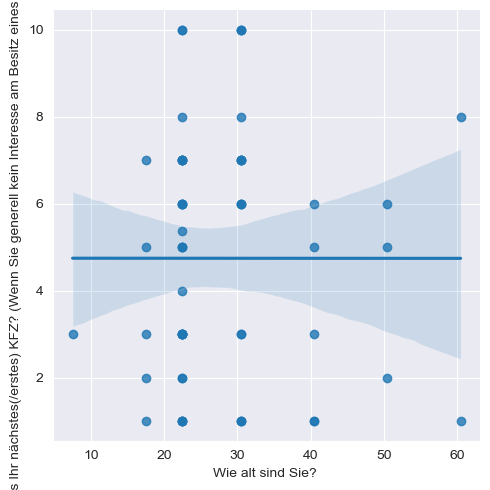

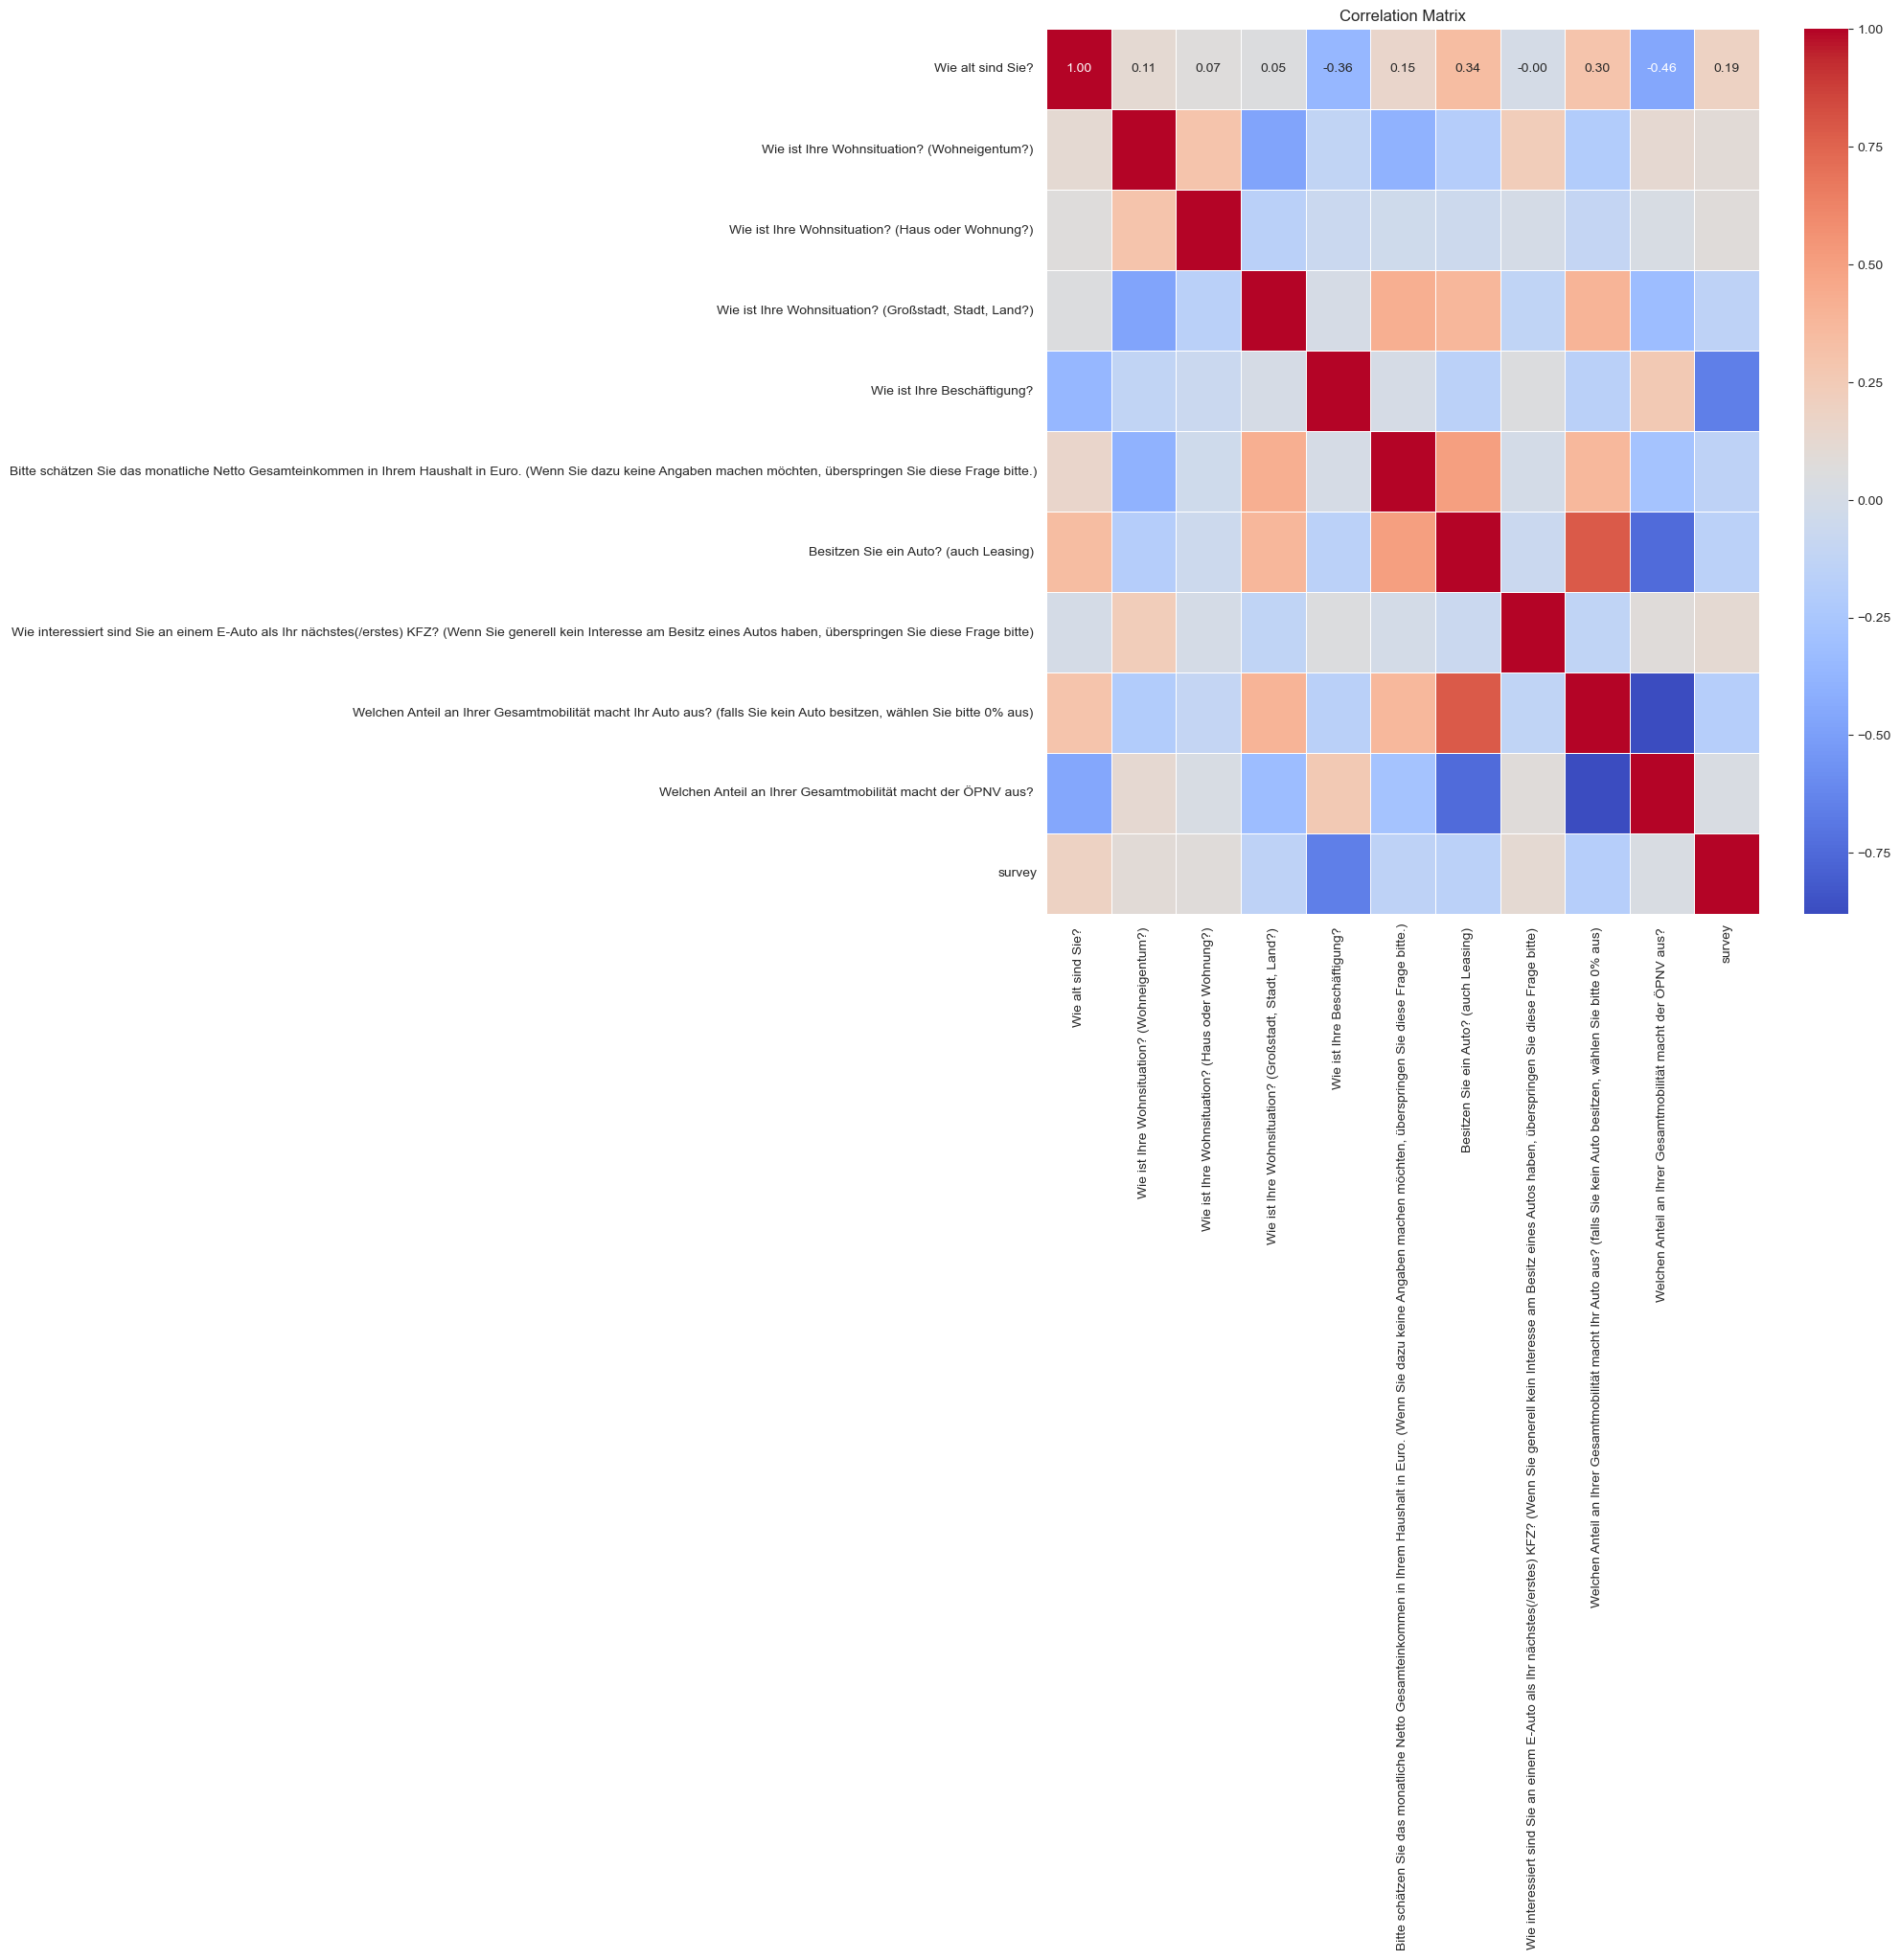

In [50]:
# Visualizing the data
visualize_data(data_copy)
# Visualizing the correlation between the features and the target

visualize_correlation(data_copy)

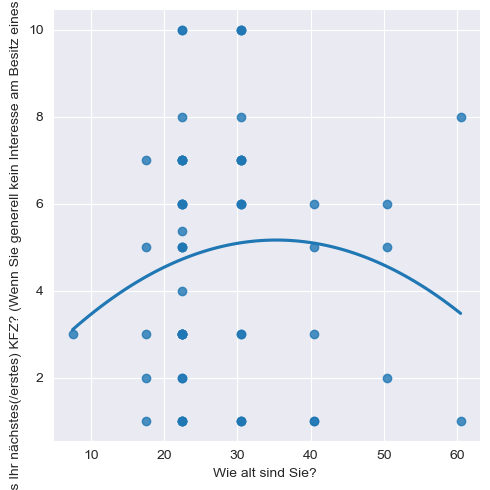

-0.05183726027812674


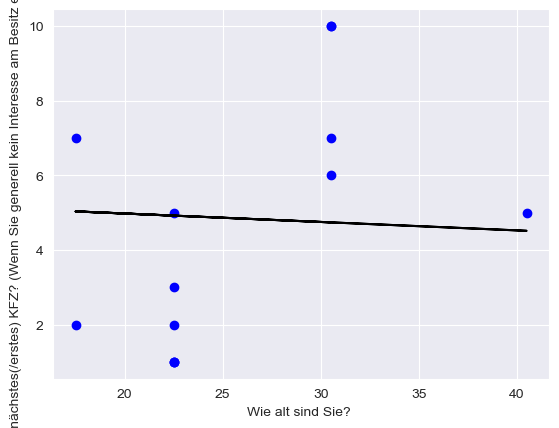

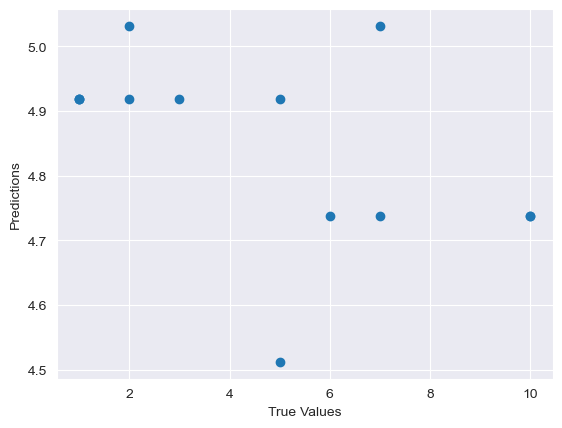

In [35]:
# linear regression analysis age vs interest in e-car
linear_regression_analysis(data_copy, age, interest_e_car)

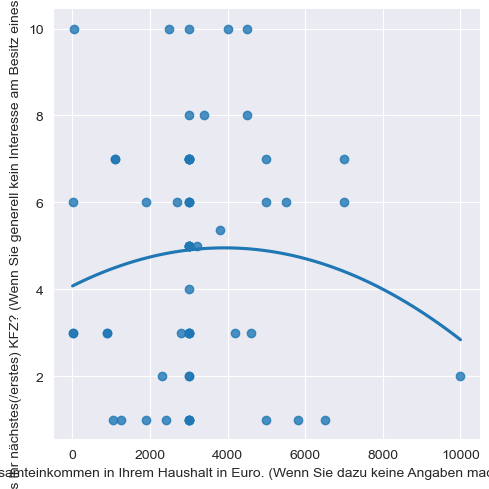

-0.10182429367279044


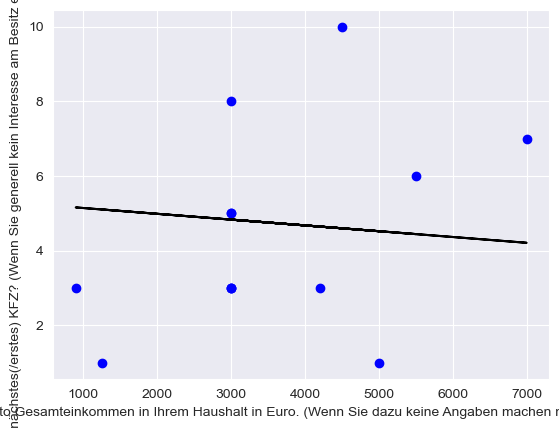

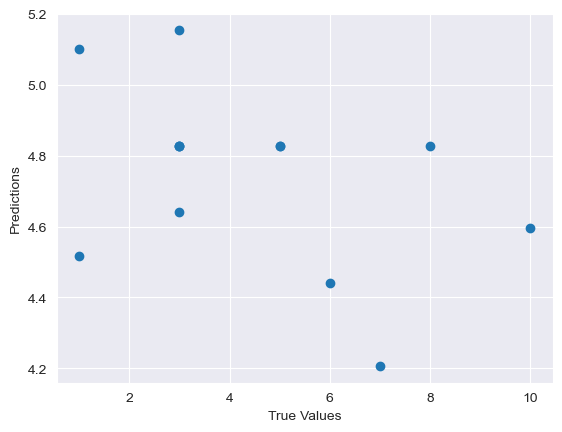

In [36]:
# linear regression analysis monthly income vs interest in e-car
linear_regression_analysis(data_copy, monthly_income, interest_e_car)

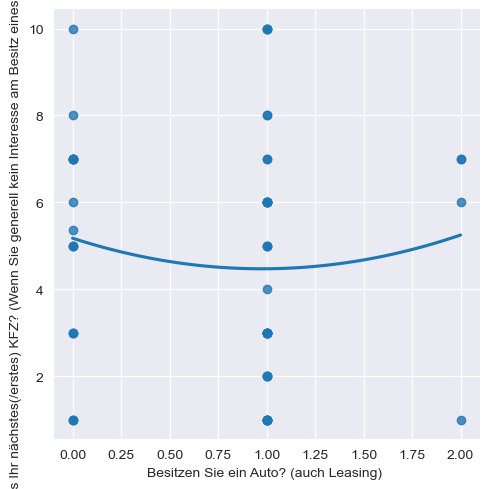

-0.12038424615119991


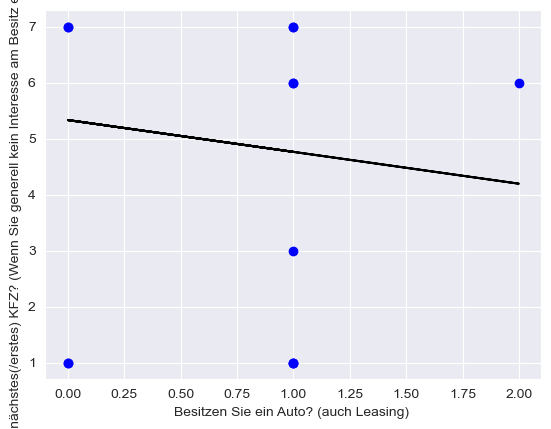

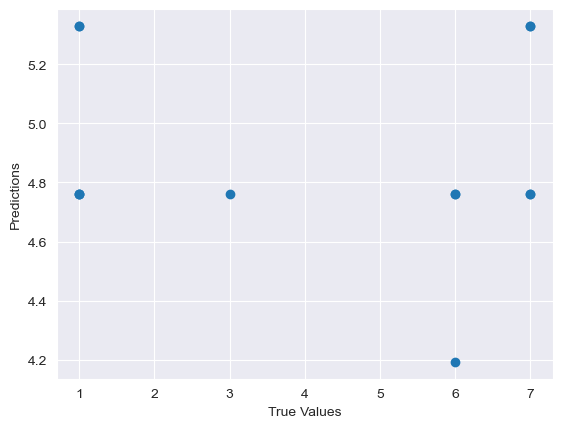

In [37]:
# linear regression analysis car ownership vs interest in e-car
linear_regression_analysis(data_copy, car_ownership, interest_e_car)

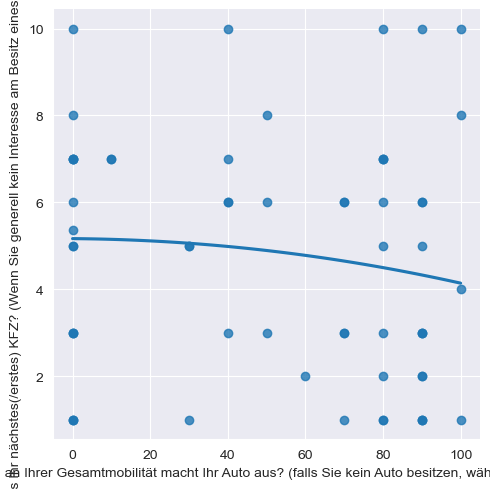

-0.17554282849555514


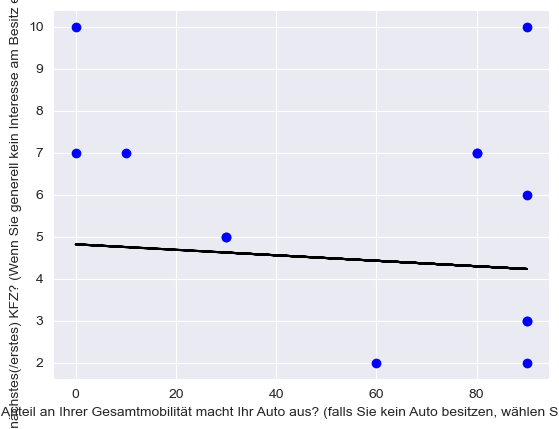

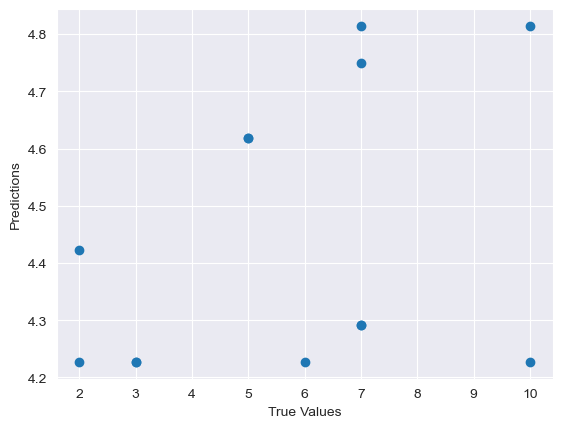

In [38]:
linear_regression_analysis(data_copy, mobility_car, interest_e_car)

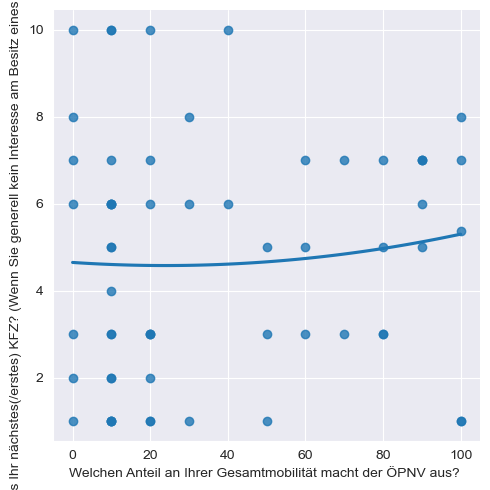

-0.08604271072208958


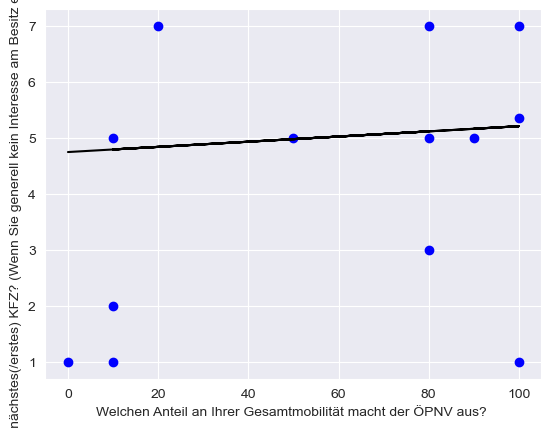

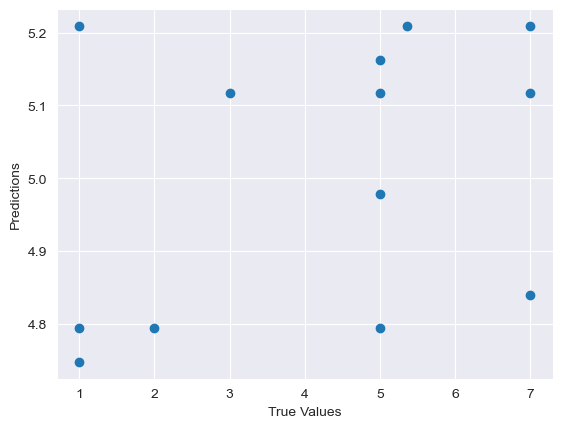

In [39]:
linear_regression_analysis(data_copy, mobility_public_transport, interest_e_car)

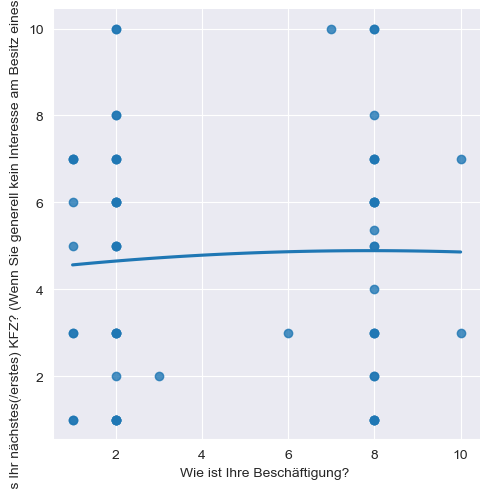

-0.2888489606825966


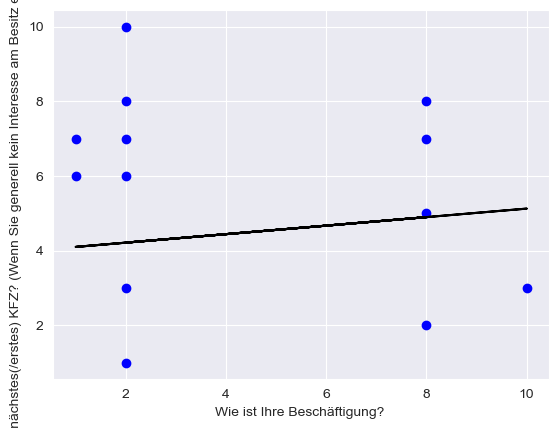

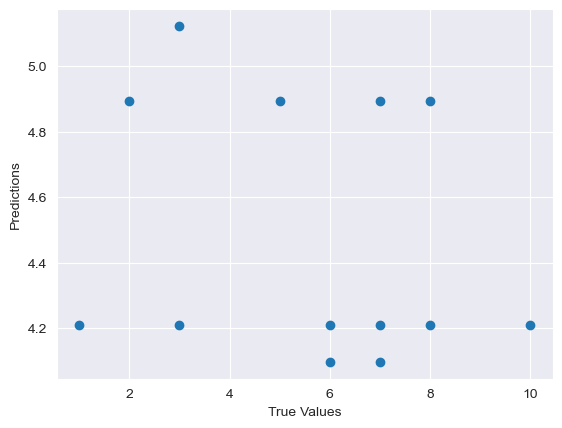

In [40]:
# employment vs interest in e-car
linear_regression_analysis(data_copy, employment, interest_e_car)

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


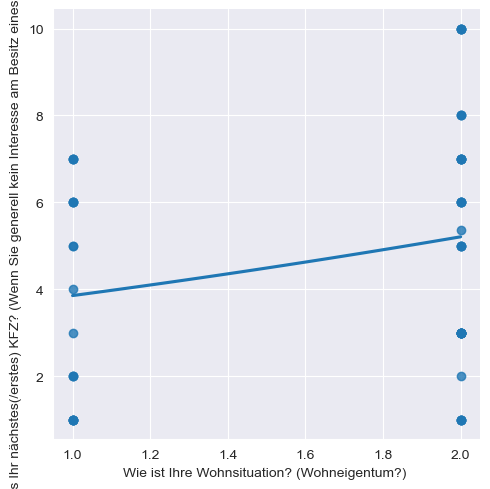

0.06808523162381852


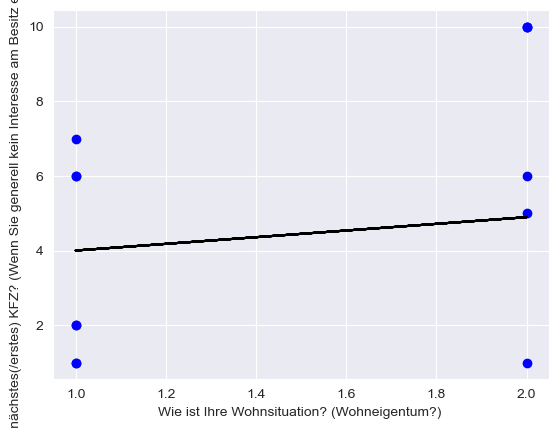

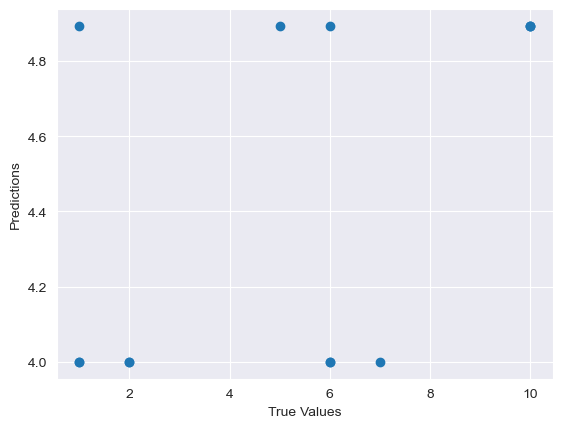

In [41]:
# living situation vs interest in e-car
linear_regression_analysis(data_copy, living_situation, interest_e_car)

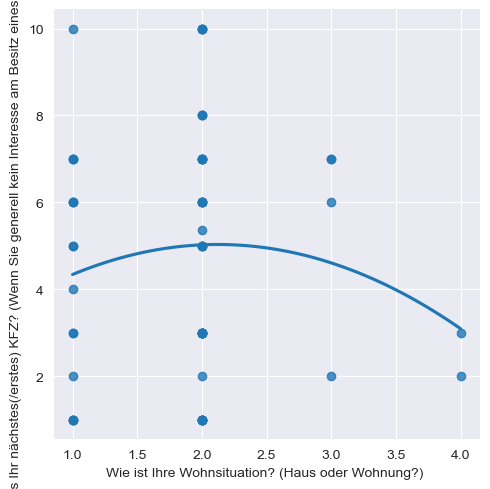

-0.011844353038725997


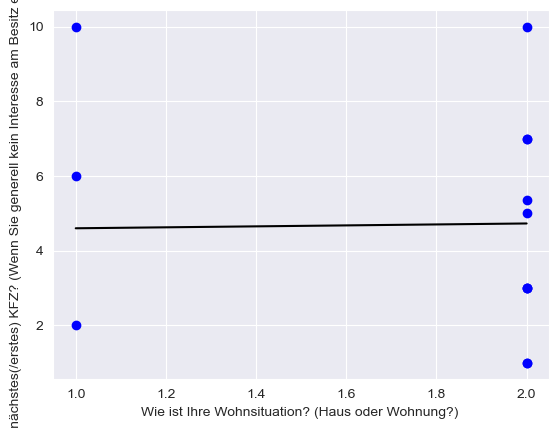

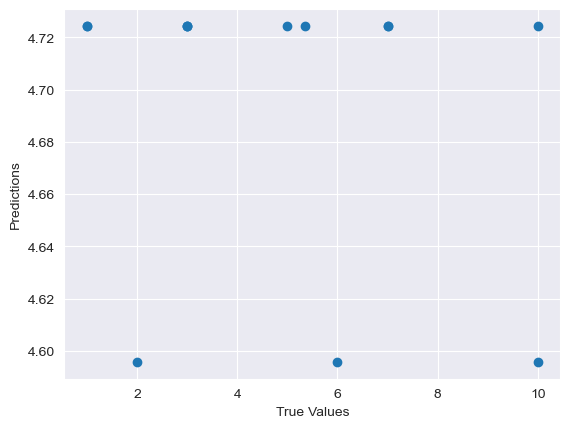

In [42]:
# living situation house apartment vs interest in e-car
linear_regression_analysis(data_copy, living_situation_house_apartment, interest_e_car)

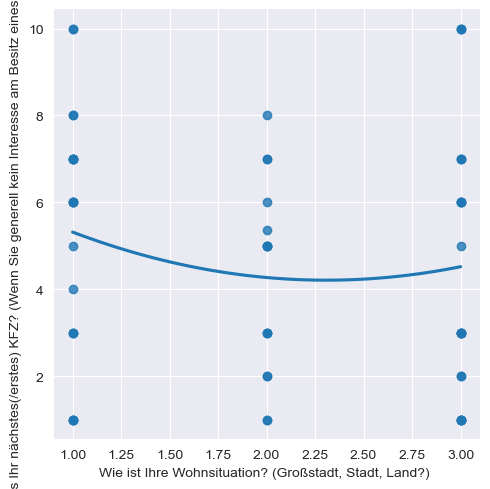

-0.04180058915369411


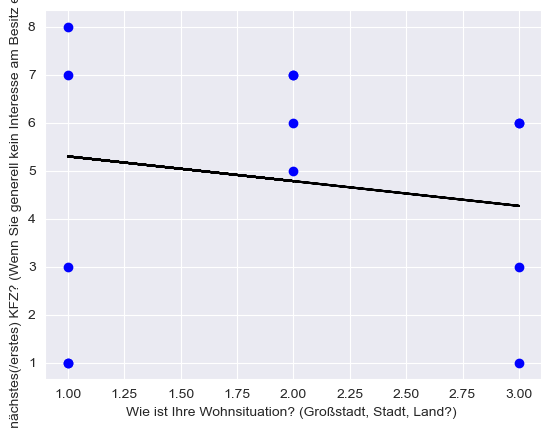

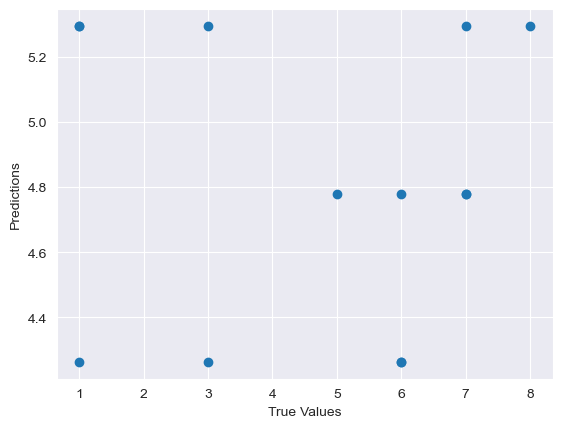

In [43]:
# living situation city vs interest in e-car
linear_regression_analysis(data_copy, living_situation_city, interest_e_car)

-0.1222897618937473


ValueError: x and y must be the same size

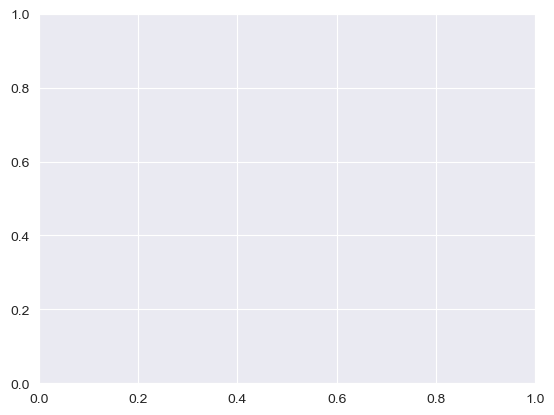

In [44]:
# age, employment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, employment], interest_e_car)

In [ ]:
# age, income vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, monthly_income], interest_e_car)

In [ ]:
# age, car ownership vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, car_ownership], interest_e_car)

In [ ]:
# age, living situation vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation], interest_e_car)

In [ ]:
# age, living situation house apartment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_house_apartment], interest_e_car)

In [ ]:
# age, living situation city vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_city], interest_e_car)

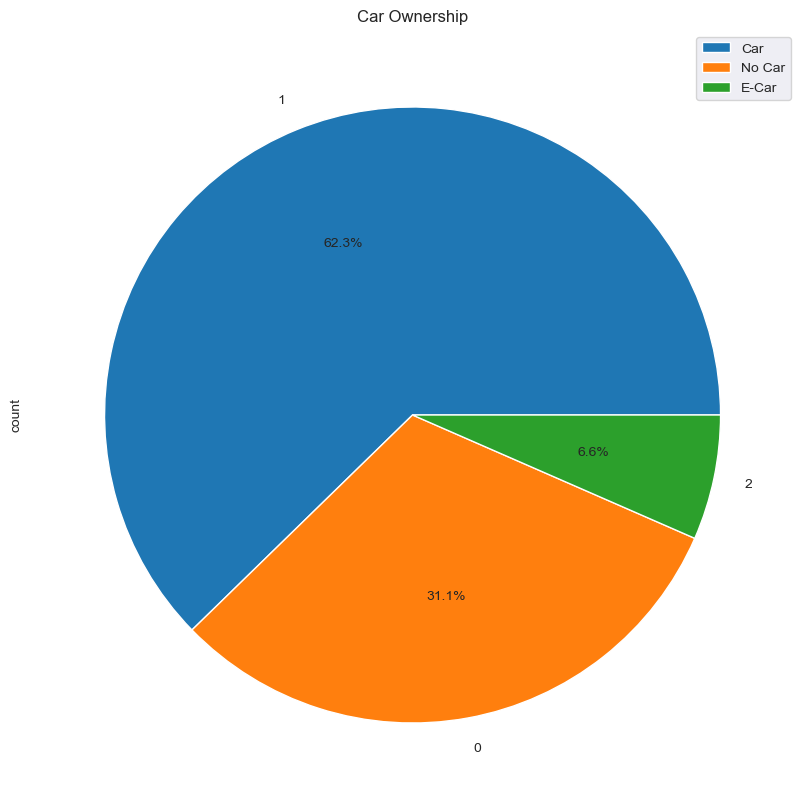

In [13]:
# piechart for mobility car
plt.figure(figsize=(10, 10))
data_copy[car_ownership].value_counts().plot.pie(autopct='%1.1f%%')
# add legend for the pie chart 0 = no car, 1 = car, 2 = e-car
plt.legend(['Auto', 'Kein Auto', 'E-Auto'])
plt.title('Auto-Besitz')
plt.show()

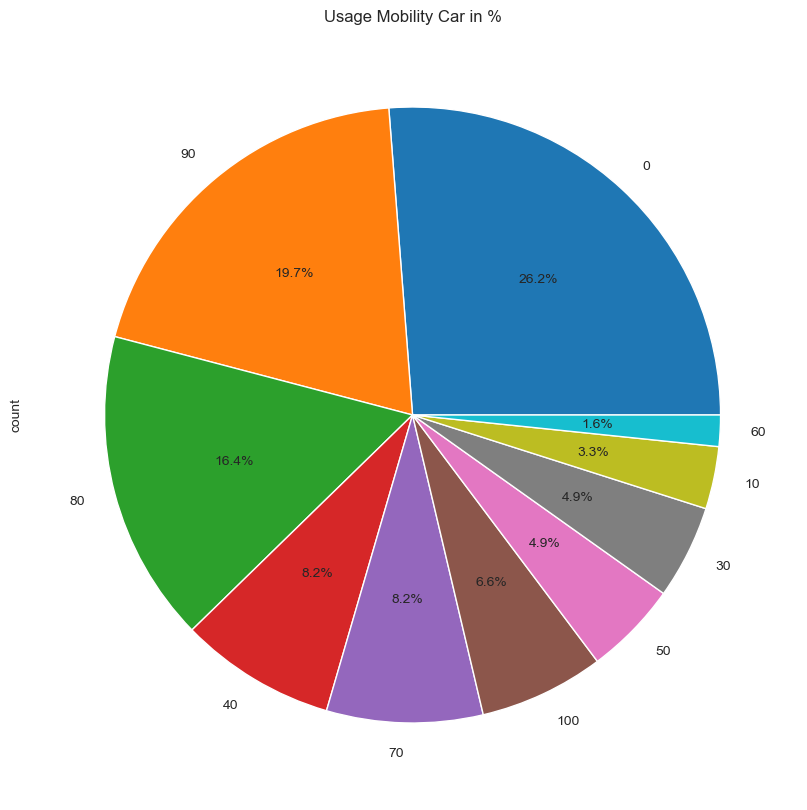

In [16]:
# piechart for mobility by car
plt.figure(figsize=(10, 10))
data_copy[mobility_car].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Auto-Nutzung in %')
plt.show()

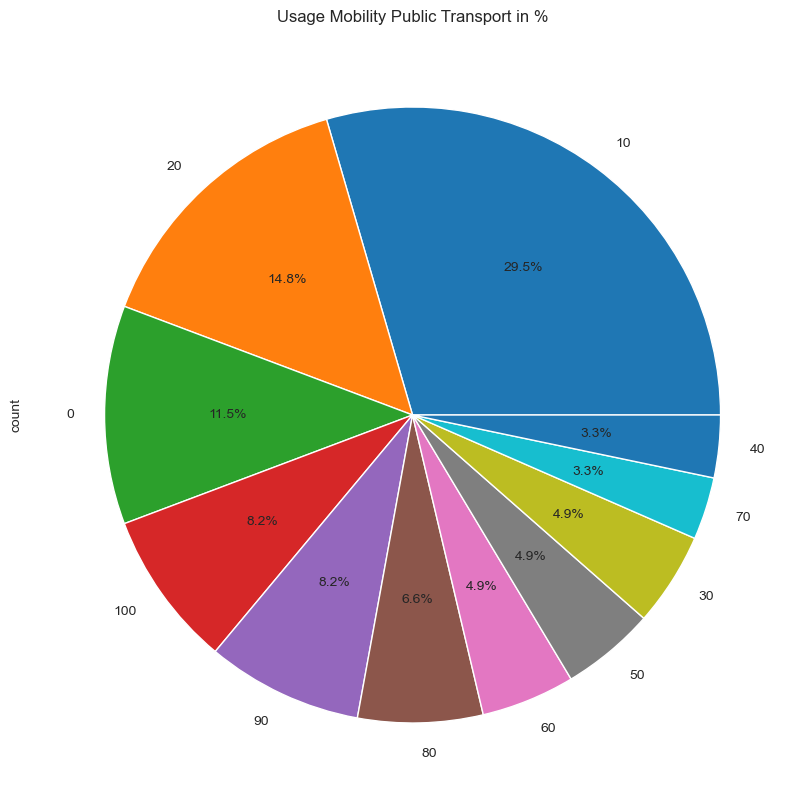

In [17]:
# piechart for mobility by public transport
plt.figure(figsize=(10, 10))
data_copy[mobility_public_transport].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Nutzung ÖPNV in %')
plt.show()

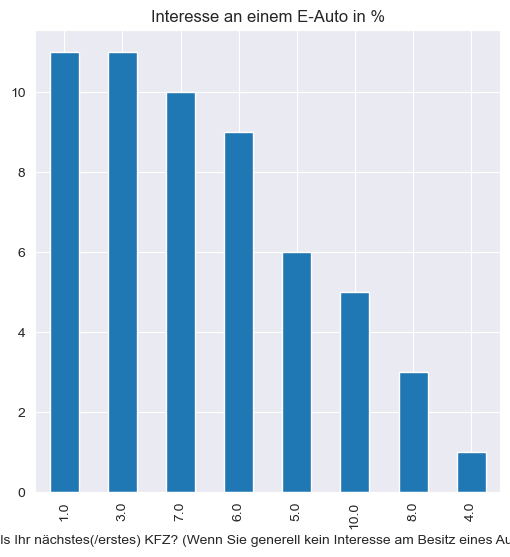

In [23]:
# piechart for interest in e-car
plt.figure(figsize=(6, 6))
# remove knn imputed values
data_copy[interest_e_car] = data_copy[interest_e_car].replace([5.362068965517241], np.nan)

#data_copy[interest_e_car].value_counts().plot.pie(autopct='%1.1f%%')
# bar chart for interest in e-car
data_copy[interest_e_car].value_counts().plot(kind='bar')
plt.title('Interesse an einem E-Auto in %')
plt.show()

TypeError: show() got an unexpected keyword argument 'legend'

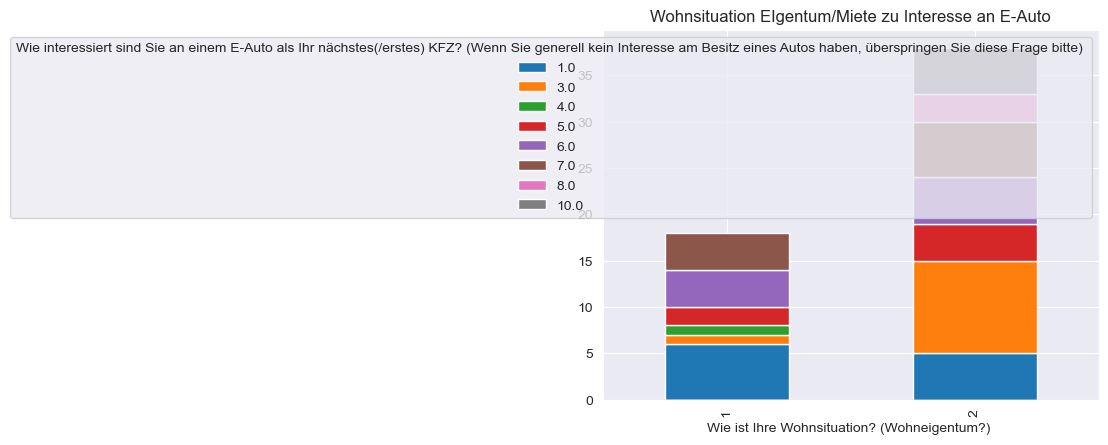

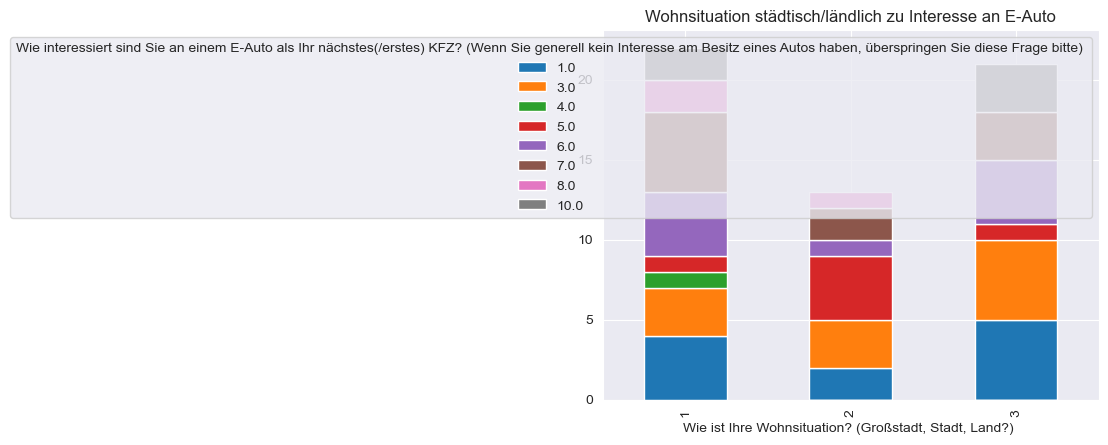

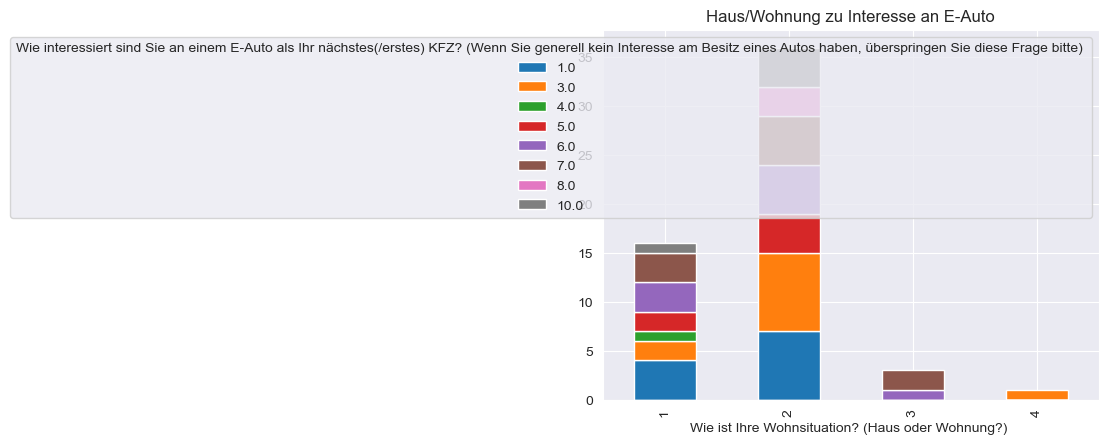

In [46]:
# Create stacked bar chart for living_situation
data_copy.groupby([living_situation, interest_e_car]).size().unstack().plot(kind='bar', stacked=True, title='Wohnsituation EIgentum/Miete zu Interesse an E-Auto')
# add legend for the bar chart Wohnsituation 1 = Wohneigentum, 2 = gemietet
# Create stacked bar chart for living_situation_city
data_copy.groupby([living_situation_city, interest_e_car]).size().unstack().plot(kind='bar', stacked=True, title='Wohnsituation städtisch/ländlich zu Interesse an E-Auto')
# add legend for the bar chart Wohnsituation 1 = Großstadt, 2 = Stadt, 3 = Land

# Create stacked bar chart for living_situation_house_apartment
data_copy.groupby([living_situation_house_apartment, interest_e_car]).size().unstack().plot(kind='bar', stacked=True, title='Haus/Wohnung zu Interesse an E-Auto')
# add legend for the bar chart Wohnsituation 1 = Haus, 2 = Wohnung, 3 = Reihenhaus, 4 = Doppelhaushälfte
plt.show()